# workflow 
1. import necessary library in one single cell
2. ingest data
3. clean data
4. choose y value
5. set the datetime as index
6. resample : up or down if necessary
7. plot observed timeseries
8. determine validation set
9. decompose the observed series
10. analyze the decomposed ts
11. if necessary, make the data stationary which  satisfy the assumption:
- data has same mean (no trend)
- data has the same variance (no heteroscedasticity)
- data should be in similiar covariance (somekind of wavelength)

12. first approach : use differencing or timeseries(t) - lag(k)
13. remove the heteroscedasticity using log transform
14. assume the data is now stattionary, one's can :
15. use ACF to determine MA order (q)
16. use PACF to determine AR order (p)
17. model the data using arima with known components
18. evaluate the model prediction on validation set
19. move forward to sarima model
18. using arima residuals to get sarima components using acf pacf
19. model sarima with known properties
20. evaluate the sarima model
21. assume the model us good, forecast to the out of observed data

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing,SimpleExpSmoothing,Holt,HoltWintersResults
from scipy.stats import normaltest,boxcox
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error as MSE
from statsmodels.tsa.api import ARIMA,SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df_train = pd.read_csv("/content/Train_SU63ISt.csv")
df_test = pd.read_csv("/content/Test_0qrQsBZ.csv")
df_sample_submit = pd.read_csv("/content/sample_submission_LSeus50.csv")

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18288 entries, 0 to 18287
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        18288 non-null  int64 
 1   Datetime  18288 non-null  object
 2   Count     18288 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 428.8+ KB


In [4]:
df_train['Datetime'] = pd.to_datetime(df_train['Datetime'])
df_train = df_train.set_index('Datetime')
df_train.head()

,ID,Count
Datetime,,
2012-08-25 00:00:00,0,8
2012-08-25 01:00:00,1,2
2012-08-25 02:00:00,2,6
2012-08-25 03:00:00,3,2
2012-08-25 04:00:00,4,2


In [5]:
df_train.isnull().sum()

ID       0
Count    0
dtype: int64

In [6]:
df_train[df_train.duplicated()]

,ID,Count
Datetime,,


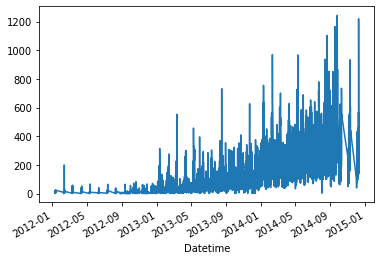

In [7]:
df_train.Count.plot()

In [8]:
df_train['log1'] = np.log1p(df_train['Count'])

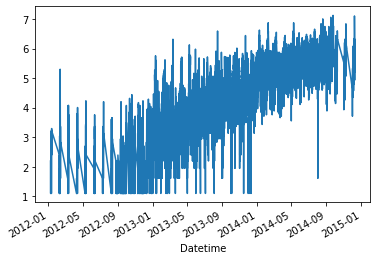

In [9]:
df_train.log1.plot()

In [10]:
#stationarity test
stationarity = adfuller(df_train.Count)
stationarity
#data is not stationary 

(-4.456560536856826,
 0.0002354046646766507,
 45,
 18242,
 {'1%': -3.430708525404171,
  '10%': -2.5668543412994906,
  '5%': -2.861698454786869},
 181026.8337109476)

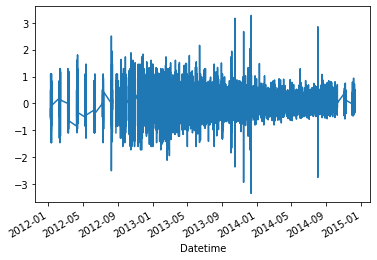

In [11]:
#differencing 1 lag
df_train['diff1']= df_train['Count'].diff(1)
df_train['diff1_log'] = df_train['log1'].diff(1)
df_train.diff1_log.plot()

In [12]:
val_set = df_train[int(len(df_train)*0.8):]
val_start = "2014-04-26 14:00:00"
val_end = "2014-09-25 23:00:00"
val_set

,ID,Count,log1,diff1,diff1_log
Datetime,,,,,
2014-04-26 14:00:00,14630,204,5.323010,-2.0,-0.009709
2014-04-26 15:00:00,14631,172,5.153292,-32.0,-0.169718
2014-04-26 16:00:00,14632,184,5.220356,12.0,0.067064
2014-04-26 17:00:00,14633,124,4.828314,-60.0,-0.392042
2014-04-26 18:00:00,14634,190,5.252273,66.0,0.423960
...,...,...,...,...,...
2014-09-25 19:00:00,18283,868,6.767343,188.0,0.243781
2014-09-25 20:00:00,18284,732,6.597146,-136.0,-0.170197
2014-09-25 21:00:00,18285,702,6.555357,-30.0,-0.041789


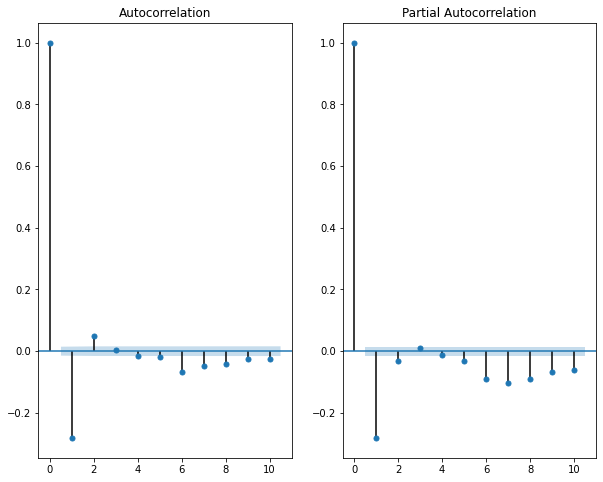

In [13]:
fig,(ax,ax2) = plt.subplots(1,2,figsize=(10,8))
acf = plot_acf(df_train['diff1_log'][1:],ax=ax,lags=10)
pacf =plot_pacf(df_train['diff1_log'][1:],ax=ax2,lags=10)

In [14]:
#arima
arima_model = ARIMA(df_train['Count'],order=(1,1,2)).fit()
val_set['arima'] = arima_model.predict(start=val_start,end=val_end)
arima_rmse = np.sqrt(MSE(val_set['Count'],val_set['arima']))
print(f"arima RMSE {arima_rmse}")

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


arima RMSE 398.02199665423484


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


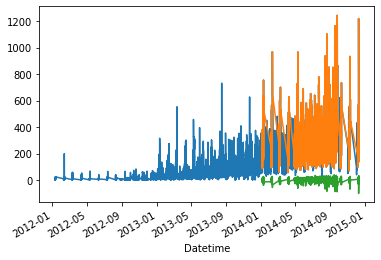

In [15]:
df_train.Count.plot()
val_set.Count.plot()
val_set.arima.plot()

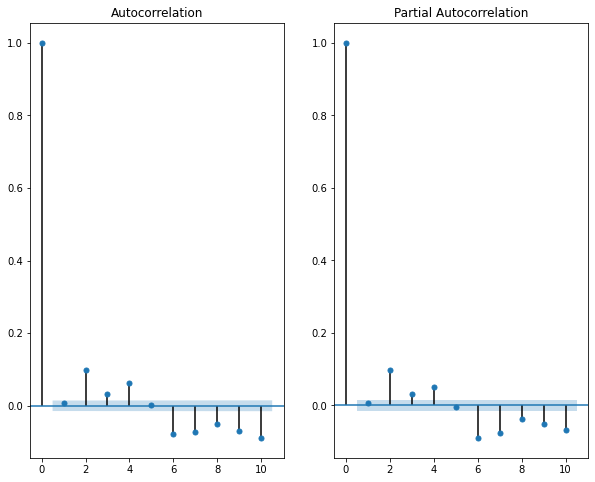

In [16]:
#searching sarima components
fig,(ax,ax2) = plt.subplots(1,2,figsize=(10,8))
acf = plot_acf(arima_model.resid,ax=ax,lags=10)
pacf =plot_pacf(arima_model.resid,ax=ax2,lags=10)

In [22]:
sarima_model = SARIMAX(df_train['Count'],order=(2,1,1),seasonal_order=(1,1,1,24)).fit()
val_set['sarima'] = sarima_model.predict(start=val_start,end=val_end)
sarima_rmse= np.sqrt(MSE(val_set['Count'],val_set['sarima']))
print(f"sarim RMSE: {sarima_rmse}")

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


sarim RMSE: 53.81321993416196


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


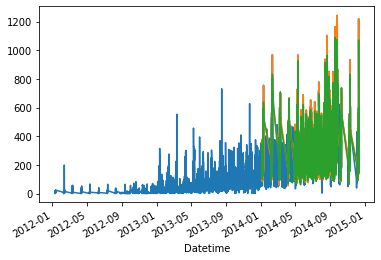

In [23]:
df_train.Count.plot()
val_set.Count.plot()
val_set.sarima.plot()

In [19]:
df_test['Datetime'] = pd.to_datetime(df_test['Datetime'])
df_test = df_test.set_index(df_test['Datetime'])
df_test.tail()

,ID,Datetime
Datetime,,
2015-04-26 19:00:00,23395,2015-04-26 19:00:00
2015-04-26 20:00:00,23396,2015-04-26 20:00:00
2015-04-26 21:00:00,23397,2015-04-26 21:00:00
2015-04-26 22:00:00,23398,2015-04-26 22:00:00
2015-04-26 23:00:00,23399,2015-04-26 23:00:00


In [20]:
df_test.drop("Datetime",axis=1,inplace=True)

In [24]:
submit_start = "2014-09-26 00:00:00"
submit_end = "2015-04-26 23:00:00"

In [25]:
pred= sarima_model.predict(start=18287,end=23398)
len(pred.values)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


5112

In [26]:
full_df = pd.concat([df_train,df_test],axis=0)
full_df.iloc[18288:23400,1] = pred.values
full_df

,ID,Count,log1,diff1,diff1_log
Datetime,,,,,
2012-08-25 00:00:00,0,8.000000,2.197225,NaN,NaN
2012-08-25 01:00:00,1,2.000000,1.098612,-6.0,-1.098612
2012-08-25 02:00:00,2,6.000000,1.945910,4.0,0.847298
2012-08-25 03:00:00,3,2.000000,1.098612,-4.0,-0.847298
2012-08-25 04:00:00,4,2.000000,1.098612,0.0,0.000000
...,...,...,...,...,...
2015-04-26 19:00:00,23395,947.069085,NaN,NaN,NaN
2015-04-26 20:00:00,23396,1017.795466,NaN,NaN,NaN
2015-04-26 21:00:00,23397,958.410024,NaN,NaN,NaN


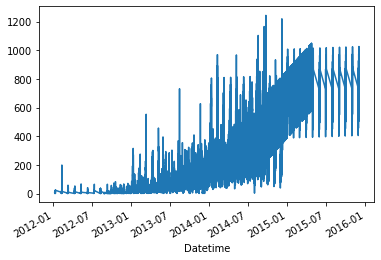

In [27]:
full_df['Count'].plot()

In [28]:
pred

18287     616.599943
18288     472.375167
18289     360.388194
18290     318.378737
18291     257.964824
            ...     
23394     947.069085
23395    1017.795466
23396     958.410024
23397     919.665740
23398     901.451722
Length: 5112, dtype: float64

In [30]:
df_test

,ID
Datetime,
2014-09-26 00:00:00,18288
2014-09-26 01:00:00,18289
2014-09-26 02:00:00,18290
2014-09-26 03:00:00,18291
2014-09-26 04:00:00,18292
...,...
2015-04-26 19:00:00,23395
2015-04-26 20:00:00,23396
2015-04-26 21:00:00,23397


In [35]:
submit_file = full_df[18288:23340].reset_index()[['ID','Count']].copy()
submit_file.to_csv("Jetrail 7 months forecast.csv",index=False,index_label=False)

In [29]:
df_sample_submit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5112 entries, 0 to 5111
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   ID      5112 non-null   int64
 1   Count   5112 non-null   int64
dtypes: int64(2)
memory usage: 80.0 KB


In [37]:
faa = pd.read_csv("Jetrail 7 months forecast.csv")
faa

,ID,Count
0,18288,616.599943
1,18289,472.375167
2,18290,360.388194
3,18291,318.378737
4,18292,257.964824
...,...,...
5047,23335,592.893699
5048,23336,649.804193
5049,23337,670.155014
5050,23338,770.925340
